# Methylation and Deamination Estimators Simulation : Liran vs. Us vs. Glm

Author: lee.carlin@mail.huji.ac.il    
Date: 2020-05-24   
Last edited: 2020-06-24   

In [1]:
# libraries:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.optimize import fsolve, newton
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy.optimize import fsolve, newton
import scipy.stats as stats  
import time
import statistics
#import seaborn as sns
import random
from tabulate import tabulate

# Second Order Condition:
def SOC_binom(t,pi, m, n):   
    return -(((n-t)*(pi**2))/(1-pi*m)**2).sum()

 
# Squaring a list:
def square(list):
    return map(lambda x: x ** 2, list)

def mult(list, constant):
    return map(lambda x: x * constant, list)

# MLE (no pi_zero):
def FOC(M,n,pi,t):    
    theta = pi*M
    A = (t/M).sum()
    oneMinusT = np.array([1]*n)-np.array(t)
    oneMinusTheta = np.array([1]*n)-theta
    B = ((oneMinusT*pi)/(oneMinusTheta)).sum()
    return (A-B)

def SOC(M,n,pi,t):    
    A = (t/M**2).sum()
    oneMinusT = np.array([1]*n)-np.array(t)
    oneMinusTheta = np.array([1]*n)-pi*M
    B = ((oneMinusT*(pi**2))/(oneMinusTheta)**2).sum()
    return (-A-B)


In [2]:
def make_scatters(df):
    fig,axs = plt.subplots(2, 2, sharey=True,sharex=True,figsize = (22,14))
    axs[0,0].scatter(df.true_m,df.liran_pi, color='yellow', alpha = 0.6,  label = 'Liran Pi model', marker="+")   
    axs[0,0].scatter(df.true_m,df.liran, color='black', alpha = 0.6,  label = 'Liran model', marker="+")
    axs[0,0].plot( np.linspace(*axs[0,0].get_xlim()), np.linspace(*axs[0,0].get_xlim()), label = '45 degree line')
    axs[0,0].set_title('MLE Deviations from True m for Liran vs. Liran Pi Model', fontsize=12)
    axs[0,1].scatter(df.true_m,df.our, color='blue', alpha = 0.6, label = 'Our model', marker="+")   
    axs[0,1].scatter(df.true_m,df.liran, color='black', alpha = 0.6, label = 'Liran model',  marker="+")
    axs[0,1].plot( np.linspace(*axs[0,1].get_xlim()), np.linspace(*axs[0,1].get_xlim()), label = '45 degree line')
    axs[0,1].set_title('MLE Deviations from True m for Liran vs. Our Model', fontsize=12)
    axs[1,0].scatter(df.true_m,df.glm, color='green', alpha = 0.6, label = 'GLM model', marker="+")    
    axs[1,0].scatter(df.true_m,df.liran, color='black', alpha = 0.6, label = 'Liran model', marker="+" )
    axs[1,0].plot( np.linspace(*axs[1,0].get_xlim()), np.linspace(*axs[1,0].get_xlim()), label = '45 degree line')
    axs[1,0].set_title('MLE Deviations from True m for Liran vs. GLM Model', fontsize=12)
    axs[1,1].scatter(df.true_m,df.our, color='blue', alpha = 0.6, label = 'Our model', marker="+" )
    axs[1,1].scatter(df.true_m,df.glm, color='green', alpha = 0.6, label = 'GLM model', marker="+")    
    axs[1,1].plot( np.linspace(*axs[1,1].get_xlim()), np.linspace(*axs[1,1].get_xlim()), label = '45 degree line')
    axs[1,1].set_title('MLE Deviations from True m for Our vs. GLM Model', fontsize=12)
    axs[0,0].legend(loc='upper left',frameon = False,fontsize= 11)
    axs[0,1].legend(loc='upper left',frameon = False,fontsize= 11)
    axs[1,0].legend(loc='upper left',frameon = False,fontsize= 11)
    axs[1,1].legend(loc='upper left',frameon = False,fontsize= 11)
    axs[0,0].set_xlabel('$m_i$', fontsize=14)
    axs[0,0].set_ylabel('$MLE_i$', fontsize=14)

In [3]:
def make_densities(df):
    fig,axs = plt.subplots(2, 2, sharey=True,sharex=True,figsize = (22,14))
    xs = np.linspace(-1,2,100)
    axs[0,0].plot(xs,gaussian_kde(df.liran)(xs), color = 'black', label = 'Liran estimator Density',lw=4) 
    axs[0,0].hist(df.liran, density=True, bins= 40, alpha = 0.2, color = 'black')
    axs[0,0].plot(xs,gaussian_kde(df.liran_pi)(xs),color = 'yellow', label = 'Liran Pi estimator Density',lw=4)
    axs[0,0].hist(df.liran_pi, density=True, bins= 40, alpha = 0.2, color = 'yellow')
    axs[0,0].axvline(np.array(df.liran).mean(),ymin=0, ymax= 0.4,linestyle = '--', label='Liran estimator mean', color = 'grey',lw=2)
    axs[0,0].axvline(np.array(df.liran_pi).mean(),ymin=0, ymax= 0.4 ,linestyle = '-.', label='Liran Pi estimator mean', color = 'violet',lw=2)
    axs[0,0].legend(fontsize = 12,frameon = False)
    axs[0,0].set_xlabel('Simulation', fontsize=14)
    axs[0,0].set_ylabel('Density', fontsize=14)
    axs[0,0].set_title('MLE Density: Liran vs. Liran Pi', fontsize=14)
    axs[0,0].set_xlim([-.25,1.25])
    
    axs[0,1].plot(xs,gaussian_kde(df.liran)(xs), color = 'black', label = 'Liran estimator Density',lw=4) 
    axs[0,1].hist(df.liran, density=True, bins= 40, alpha = 0.2, color = 'black')
    axs[0,1].plot(xs,gaussian_kde(df.our)(xs),color = 'blue', label = 'Our estimator Density',lw=4)
    axs[0,1].hist(df.our, density=True, bins= 40, alpha = 0.2, color = 'blue')
    axs[0,1].axvline(np.array(df.liran).mean(),ymin=0, ymax= 0.4,linestyle = '--', label='Liran estimator mean', color = 'grey',lw=2)
    axs[0,1].axvline(np.array(df.our).mean(),ymin=0, ymax= 0.4 ,linestyle = '-.', label='Our estimator mean', color = 'violet',lw=2)
    axs[0,1].legend(fontsize = 12,frameon = False)
    axs[0,1].set_xlabel('Simulation', fontsize=14)
    axs[0,1].set_ylabel('Density', fontsize=14)
    axs[0,1].set_title('MLE Density: Liran vs. Our', fontsize=14)
    axs[0,1].set_xlim([-.25,1.25])
    
    axs[1,0].plot(xs,gaussian_kde(df.liran)(xs), color = 'black', label = 'Liran estimator Density',lw=4) 
    axs[1,0].hist(df.liran, density=True, bins= 40, alpha = 0.2, color = 'black')
    axs[1,0].plot(xs,gaussian_kde(df.glm)(xs),color = 'green', label = 'GLM estimator Density',lw=4)
    axs[1,0].hist(df.glm, density=True, bins= 40, alpha = 0.2, color = 'green')
    axs[1,0].axvline(np.array(df.liran).mean(),ymin=0, ymax= 0.4,linestyle = '--', label='Liran estimator mean', color = 'grey',lw=2)
    axs[1,0].axvline(np.array(df.glm).mean(),ymin=0, ymax= 0.4 ,linestyle = '-.', label='GLM estimator mean', color = 'violet',lw=2)
    axs[1,0].legend(fontsize = 12,frameon = False)
    axs[1,0].set_xlabel('Simulation', fontsize=14)
    axs[1,0].set_ylabel('Density', fontsize=14)
    axs[1,0].set_title('MLE Density: Liran vs. GLM', fontsize=14)
    axs[1,0].set_xlim([-.25,1.25])
    
    axs[1,1].plot(xs,gaussian_kde(df.our)(xs), color = 'blue', label = 'Our estimator Density',lw=4) 
    axs[1,1].hist(df.our, density=True, bins= 40, alpha = 0.2, color = 'blue')
    axs[1,1].plot(xs,gaussian_kde(df.glm)(xs),color = 'green', label = 'GLM estimator Density',lw=4)
    axs[1,1].hist(df.glm, density=True, bins= 40, alpha = 0.2, color = 'green')
    axs[1,1].axvline(np.array(df.our).mean(),ymin=0, ymax= 0.4,linestyle = '--', label='Our estimator mean', color = 'grey',lw=2)
    axs[1,1].axvline(np.array(df.glm).mean(),ymin=0, ymax= 0.4 ,linestyle = '-.', label='GLM estimator mean', color = 'violet',lw=2)
    axs[1,1].legend(fontsize = 12,frameon = False)
    axs[1,1].set_xlabel('Simulation', fontsize=14)
    axs[1,1].set_ylabel('Density', fontsize=14)
    axs[1,1].set_title('MLE Density: Our vs. GLM', fontsize=14)
    axs[1,1].set_xlim([-.25,1.25])

# Simulating Data:

Using a position depended Binomial model $t_{r} \sim Bern(\theta_{r})$   
for  $\theta$ such that  $\quad \theta_{r} =  m \times\pi _{r}$  
simulate a vector of $t_r$ for $r \in [1,2,\dots,c]$ and estimate $m$ using Liran's and our models:

Function:(hidden)

In [4]:


###########################################
def sim(input_dict):
    sample_len = input_dict['sample_len'] 
    coverage_mean  = input_dict['coverage_mean'] 
    coverage_sd = input_dict['coverage_sd'] 
    m_sd = input_dict['m_sd'] 
    m_low = input_dict['m_low'] 
    m_high = input_dict['m_high'] 
    m_initial_guess = input_dict['m_initial_guess'] 
    pi_dist = input_dict['pi_dist']
    weights =input_dict['weights']
    limitBounds = input_dict['limitBounds']
    pi_calib_runs = input_dict['pi_calib_runs']
    full_verbal = input_dict['full_verbal']
    # list objects for accounting:
    t_list = []
    liran_list = []
    liran_pi_list = []
    liran_sd_list = []
    our_list = []
    our_sd_list = []
    glm_list = []
    pi_list = []
    pi_mean_list = []
    m_list = []
    glm_list = []
    ###########################################

    # Simulating Data:
    rng = range(0,sample_len) 
    pi_calib = 0.1
    for i in range(pi_calib_runs):
        for i in rng:
            # Sampling m:
            m = random.sample([m_low,m_high],1)[0]
            m = np.random.normal(m,m_sd,1)[0]
            if m>=1:
                m  = 0.99999
            elif m <=0:
                m = 0.00001
            #Sampling coverage:
            coverage = int(np.random.normal(coverage_mean, coverage_sd))
            # Sampling pi:
            pi = np.array(random.choices(pi_dist,weights=weights,k=coverage))
            theta = pi*m # Defining theta
            # Limiting theta:
            theta[theta>1]=1
            theta[theta<0]=0
            # Sampling t_i from a binomial(theta):
            t = np.random.binomial(1,theta)

            # Estimating using Liran's:
            solution_liran = t.sum()/(coverage*pi_calib) #MLE: m = t/(pi*n)
            # Estimating using Liran's but using real Pi:
            solution_liran_pi = t.sum()/(coverage*np.array(pi_dist)*np.array(weights)).sum() 
            # Estimating m using our model: 
            solution_our = fsolve(func=FOC, x0=m_initial_guess,args=(coverage,pi,t))[0]
            # Estimating m using GLM model: 
            df = pd.DataFrame(list(zip(pi,t)),columns = ['pi','t'])
            try: 
                solution_glm = sm.formula.glm("t ~ 0 + pi",
                                              family=sm.families.Binomial(link=sm.families.links.identity), 
                                              data=df).fit().params['pi']
            except:
                solution_glm=0
            
            # Bounding estimators:
            if limitBounds:
                solution_liran = 0 if solution_liran<0 else solution_liran
                solution_liran = 1 if solution_liran>1 else solution_liran
                solution_liran_pi = 0 if solution_liran_pi<0 else solution_liran_pi
                solution_liran_pi = 1 if solution_liran_pi>1 else solution_liran_pi
                solution_our = 0 if solution_our<0 else solution_our
                solution_our = 1 if solution_our>1 else solution_our
                solution_glm = 0 if solution_glm<0 else solution_glm
                solution_glm = 1 if solution_glm>1 else solution_glm
            
            # Appending estimators:
            liran_list.append(solution_liran)
            liran_sd_list.append(np.sqrt(1/(-SOC_binom(t,pi_calib, solution_liran, coverage))))
            liran_pi_list.append(solution_liran_pi)
            our_list.append(solution_our)
            our_sd_list.append(np.sqrt(1/(-SOC(solution_our,coverage,pi,t))))
            glm_list.append(solution_glm)            

            # Accounting:
            pi_list.append(pi)
            pi_mean_list.append(pi.mean())
            m_list.append(m)
            t_list.append(t)
            pi_calib = np.array(pi_mean_list).mean()

    output_df = pd.DataFrame(list(zip(m_list, pi_list ,t_list,liran_list,liran_pi_list,our_list,glm_list)), 
                   columns =['samp_m', 'samp_p','samp_t','liran_est','liran_pi_est','our_est','glm_est']) 
    #output_df.to_pickle('/Users/leecarlin/Dropbox (Personal)/School/deamination/simulation_MLE_35_coverage.pickle')
    
    if full_verbal:
        print('The empirical mean of m    : {:,}'.format(np.array(m_list).mean()))
        print('The empirical mean of pi   : {:,}'.format(np.array(pi_mean_list).mean()))
        print('The empirical mean of theta: {:,}\n'.format(np.array(pi_mean_list).mean()*np.array(m_list).mean()))

        print('The mean of the Liran model estimation   : {:,}'.format(np.array(liran_list).mean()))
        print('The mean of the Liran pi model estimation: {:,}'.format(np.array(liran_pi_list).mean()))
        print('The mean of the Our model estimation     : {:,}'.format(np.array(our_list).mean()))
        print('The mean of the GLM model estimation     : {:,}\n'.format(np.array(glm_list).mean()))

        print('The std of the Liran model estimation: {:,}'.format(np.array(liran_list).std()))
        print('The std of the Liran pi model estimation: {:,}'.format(np.array(liran_pi_list).std()))
        print('The std of the Our model estimation  : {:,}'.format(np.array(our_list).std()))
        print('The std of the GLM model estimation  : {:,}\n'.format(np.array(glm_list).std()))

        print('The mean of the Liran model MLE STD: {:,}'.format(np.array(liran_sd_list).mean()))
        our_sd_list_rmna = np.array(our_sd_list)[~np.isnan(np.array(our_sd_list))]
        print('The mean of the Our model MLE STD  : {:,}\n'.format(np.array(our_sd_list_rmna).mean()))
    
    MSE_liran = np.sqrt(((np.array(liran_list)-np.array(m_list))**2).mean())
    MSE_our = np.sqrt(((np.array(our_list)-np.array(m_list))**2).mean())
    print('RMSE of Lirans Model        : {:,}'.format(MSE_liran))
    print('RMSE of Our Model           : {:,}'.format(MSE_our))
    RMSE_diff_our = (MSE_our-MSE_liran)/MSE_liran
    print('RMSE DIfference (vs. Liran) : {:%}\n'.format(RMSE_diff_our))
    
    MSE_glm = np.sqrt(((np.array(glm_list)-np.array(m_list))**2).mean())
    print('RMSE of GLM Model           : {:,}'.format(MSE_glm))
    RMSE_diff_glm = (MSE_glm-MSE_liran)/MSE_liran
    print('RMSE DIfference (vs. Liran) : {:%}\n'.format(RMSE_diff_glm))
    
    output_est = pd.DataFrame(list(zip(m_list,liran_list,liran_pi_list,our_list,glm_list)),columns =['true_m','liran','liran_pi','our','glm'])
    
    output = {'t_list':t_list,
             'liran_list':liran_list,
             'liran_pi_list':liran_pi_list,
             'our_list':our_list,
             'glm_list':glm_list,
             'liran_sd_list':liran_sd_list,
             'our_sd_list':our_sd_list,
             'pi_list':pi_list,
             'pi_mean_list':pi_mean_list,
             'm_list':m_list,
             'output_est':output_est,
             'output_df':output_df,
             'RMSE':{'liran':MSE_liran,
                    'our':MSE_our,
                    'glm':MSE_glm},
             'RMSE_diff':{'our':RMSE_diff_our,
                         'glm':RMSE_diff_glm}}
    return(output)

In [5]:
import warnings
warnings.filterwarnings("ignore", message="")

### Simulation Examples:  

*Coverage:*
* Low = 35
* Medium  = 200
* High  =  600

*$\pi$ values:*  
* "Flat"  = [0.3,0.2,0.1,0.05]
* "Sharp"  =   [0.8,0.6,0.4,0.02]

*$\pi$ weights:*  
* "Normal"  = [3/100,3/100,4/100,90/100]
* "Shifted = [10/100,10/100,10/100,70/100]
            

In [6]:
params = {'coverage':{'low': 35 ,
                      'medium': 200, 
                      'high': 600},
          'pi_values':{'flat':[0.3,0.2,0.1,0.05], 
                       'sharp':[0.8,0.6,0.4,0.02]},
          'pi_weights':{'normal':[3/100,3/100,4/100,90/100],
                        'shifted': [10/100,10/100,10/100,70/100]}}

In [7]:
##########################################

### Example 1: 
* "Low" Coverage  : 35 reads
* "Flat" $\pi$  :   [0.3,0.3,0.1,0.05]
* "Normal" $\pi$ wights  :   [3/100,3/100,4/100,90/100]

In [8]:
# Example 1:
###########################################
input_dict1 = {'sample_len' : 1000, 
              'coverage_mean'  : params['coverage']['low'],
              'coverage_sd' : 5,
              'm_sd' : 0.5, 
              'm_low' : 0.2, 
              'm_high' : 0.7, 
              'm_initial_guess' : 0.5,
              'limitBounds': True,
              'pi_calib_runs':1,
              'full_verbal': False,
              'pi_dist_str': 'flat',
              'pi_dist': params['pi_values']['flat'],
              'pi_weights_str': 'normal',
              'weights' : params['pi_weights']['normal']
             }
output1 = sim(input_dict1)

RMSE of Lirans Model        : 0.3219093350974776
RMSE of Our Model           : 0.3203324321342816
RMSE DIfference (vs. Liran) : -0.489859%

RMSE of GLM Model           : 0.3203324625739466
RMSE DIfference (vs. Liran) : -0.489850%



### Example 2: 
* "Low" Coverage  : 35 reads
* "Sharp" $\pi$       :   [0.8,0.6,0.4,0.02]
* "Normal" $\pi$ weights  :   [3/100,3/100,4/100,90/100]

In [9]:
# Example 2:
###########################################
input_dict2 = {'sample_len' : 1000, 
              'coverage_mean'  : params['coverage']['low'],
              'coverage_sd' : 5,
              'm_sd' : 0.5, 
              'm_low' : 0.2, 
              'm_high' : 0.7, 
              'm_initial_guess' : 0.5,
              'limitBounds': True,
              'pi_calib_runs':1,
              'full_verbal': False,
              'pi_dist_str': 'sharp',
              'pi_dist': params['pi_values']['sharp'],
              'pi_weights_str': 'normal',
              'weights' : params['pi_weights']['normal']
             }
output2 = sim(input_dict2)

RMSE of Lirans Model        : 0.30457412943226275
RMSE of Our Model           : 0.28853795494469636
RMSE DIfference (vs. Liran) : -5.265114%

RMSE of GLM Model           : 0.2897896817416144
RMSE DIfference (vs. Liran) : -4.854138%



### Example 3: 
* "Low" Coverage  : 35 reads
* "Sharp" $\pi$       :   [0.8,0.6,0.4,0.02]
* "Shifted" $\pi$ weights  :   [10/100,10/100,10/100,70/100]

In [10]:
# Example 3:
###########################################
input_dict3 = {'sample_len' : 1000, 
              'coverage_mean'  : params['coverage']['low'],
              'coverage_sd' : 5,
              'm_sd' : 0.5, 
              'm_low' : 0.2, 
              'm_high' : 0.7, 
              'm_initial_guess' : 0.5,
              'limitBounds': True,
              'pi_calib_runs':1,
              'full_verbal': False,
              'pi_dist_str': 'sharp',
              'pi_dist': params['pi_values']['sharp'],
              'pi_weights_str': 'shifted',
              'weights' : params['pi_weights']['shifted']
             }
output3 = sim(input_dict3)

RMSE of Lirans Model        : 0.1991811735403034
RMSE of Our Model           : 0.17333667251027196
RMSE DIfference (vs. Liran) : -12.975373%

RMSE of GLM Model           : 0.1733366431381292
RMSE DIfference (vs. Liran) : -12.975388%



### Example 4: 
* "Medium" Coverage  : 200 reads
* "Flat" $\pi$       :   [0.3,0.2,0.1,0.05]
* "Normal" $\pi$ weights  :   [3/100,3/100,4/100,90/100]

In [11]:
# Example 4:
###########################################
input_dict4 = {'sample_len' : 1000, 
              'coverage_mean'  : params['coverage']['medium'],
              'coverage_sd' : 5,
              'm_sd' : 0.5, 
              'm_low' : 0.2, 
              'm_high' : 0.7, 
              'm_initial_guess' : 0.5,
              'limitBounds': True,
              'pi_calib_runs':1,
              'full_verbal': False,
              'pi_dist_str': 'flat',
              'pi_dist': params['pi_values']['flat'],
              'pi_weights_str': 'normal',
              'weights' : params['pi_weights']['normal']
             }
output4 = sim(input_dict4)

RMSE of Lirans Model        : 0.1581130038072391
RMSE of Our Model           : 0.15735162057840316
RMSE DIfference (vs. Liran) : -0.481544%

RMSE of GLM Model           : 0.1570462407974122
RMSE DIfference (vs. Liran) : -0.674684%



### Example 5: 
* "Medium" Coverage  : 200 reads
* "flat" $\pi$ : [0.3,0.2,0.1,0.05]
* "Shifted" $\pi$ weights  :   [10/100,10/100,10/100,70/100]

In [19]:
# Example 5:
###########################################
input_dict5 = {'sample_len' : 1000, 
              'coverage_mean'  : params['coverage']['medium'],
              'coverage_sd' : 5,
              'm_sd' : 0.5, 
              'm_low' : 0.2, 
              'm_high' : 0.7, 
              'm_initial_guess' : 0.5,
              'limitBounds': True,
              'pi_calib_runs':1,
              'full_verbal': False,
              'pi_dist_str': 'flat',
              'pi_dist': params['pi_values']['flat'],
              'pi_weights_str': 'shifted',
              'weights' : params['pi_weights']['shifted']
             }
output5 = sim(input_dict5)

RMSE of Lirans Model        : 0.12828360547747703
RMSE of Our Model           : 0.12659935475523584
RMSE DIfference (vs. Liran) : -1.312912%

RMSE of GLM Model           : 0.12501465723774588
RMSE DIfference (vs. Liran) : -2.548220%



### Example 6: 
* "High" Coverage  : 600 reads
* "Sharp" $\pi$ :  [0.8,0.6,0.4,0.02]
* "Normal" $\pi$ weights  : [3/100,3/100,4/100,90/100]

In [20]:
# Example 6:
###########################################
input_dict6 = {'sample_len' : 1000, 
              'coverage_mean'  : params['coverage']['high'],
              'coverage_sd' : 5,
              'm_sd' : 0.5, 
              'm_low' : 0.2, 
              'm_high' : 0.7, 
              'm_initial_guess' : 0.5,
              'limitBounds': True,
              'pi_calib_runs':1,
              'full_verbal': False,
              'pi_dist_str': 'sharp',
              'pi_dist': params['pi_values']['sharp'],
              'pi_weights_str': 'normal',
              'weights' : params['pi_weights']['normal']
             }
output6 = sim(input_dict6)

RMSE of Lirans Model        : 0.09101096632787148
RMSE of Our Model           : 0.07639511493053723
RMSE DIfference (vs. Liran) : -16.059440%

RMSE of GLM Model           : 0.07409828053000499
RMSE DIfference (vs. Liran) : -18.583130%



### Example 7: 
* "Medium" Coverage  : 200 reads
* "Sharp" $\pi$ : [0.8,0.6,0.4,0.02]
* "Shifted" $\pi$ weights  :   [10/100,10/100,10/100,70/100]

In [14]:
# Example 7:
###########################################
input_dict7 = {'sample_len' : 1000, 
              'coverage_mean'  : params['coverage']['medium'],
              'coverage_sd' : 5,
              'm_sd' : 0.5, 
              'm_low' : 0.2, 
              'm_high' : 0.7, 
              'm_initial_guess' : 0.5,
              'limitBounds': True,
              'pi_calib_runs':1,
              'full_verbal': False,
              'pi_dist_str': 'sharp',
              'pi_dist': params['pi_values']['sharp'],
              'pi_weights_str': 'shifted',
              'weights' : params['pi_weights']['shifted']
             }
output7 = sim(input_dict7)

RMSE of Lirans Model        : 0.09033206553055881
RMSE of Our Model           : 0.07301686014441726
RMSE DIfference (vs. Liran) : -19.168393%

RMSE of GLM Model           : 0.07175563632844759
RMSE DIfference (vs. Liran) : -20.564601%



In [22]:
data = [[input_dict1['coverage_mean'],input_dict1['pi_dist_str'],input_dict1['pi_weights_str'],round(output1['RMSE_diff']['our'],4)],
 [input_dict2['coverage_mean'],input_dict2['pi_dist_str'],input_dict2['pi_weights_str'],100*round(output2['RMSE_diff']['our'],4)],
 [input_dict3['coverage_mean'],input_dict3['pi_dist_str'],input_dict3['pi_weights_str'],100*round(output3['RMSE_diff']['our'],4)],
 [input_dict4['coverage_mean'],input_dict4['pi_dist_str'],input_dict4['pi_weights_str'],100*round(output4['RMSE_diff']['our'],4)],
 [input_dict5['coverage_mean'],input_dict5['pi_dist_str'],input_dict5['pi_weights_str'],100*round(output5['RMSE_diff']['our'],4)],
 [input_dict6['coverage_mean'],input_dict6['pi_dist_str'],input_dict6['pi_weights_str'],100*round(output6['RMSE_diff']['our'],4)],
 [input_dict7['coverage_mean'],input_dict7['pi_dist_str'],input_dict7['pi_weights_str'],100*round(output7['RMSE_diff']['our'],4)]
]
data = pd.DataFrame(data,columns=['coverage','pi_values','pi_weights','RMSE_Diff'])

In [23]:

print(tabulate(data,headers = ['coverage','pi_values','pi_weights','RMSE_Diff']))

      coverage  pi_values    pi_weights      RMSE_Diff
--  ----------  -----------  ------------  -----------
 0          35  flat         normal            -0.0049
 1          35  sharp        normal            -5.27
 2          35  sharp        shifted          -12.98
 3         200  flat         normal            -0.48
 4         200  flat         shifted           -1.31
 5         600  sharp        normal           -16.06
 6         200  sharp        shifted          -19.17


### Plots:

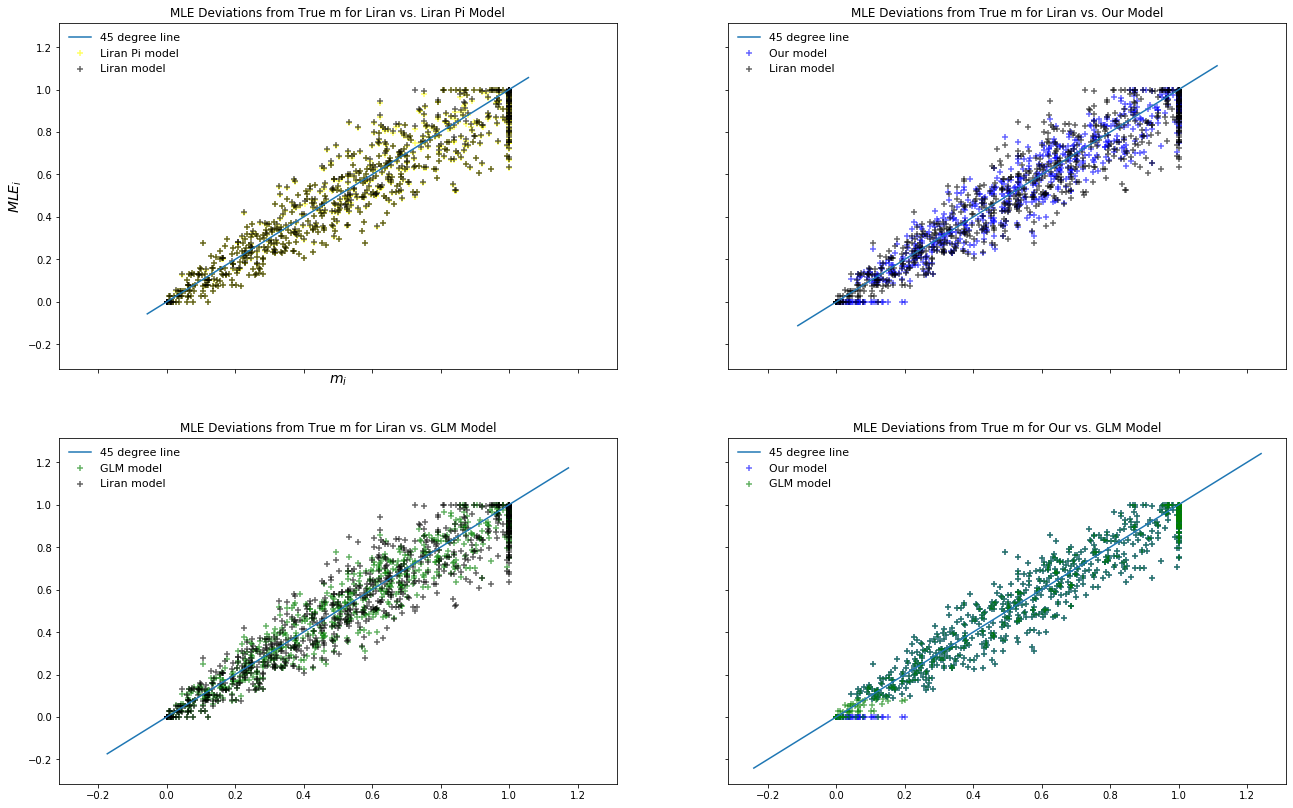

In [17]:
make_scatters(output7['output_est'])

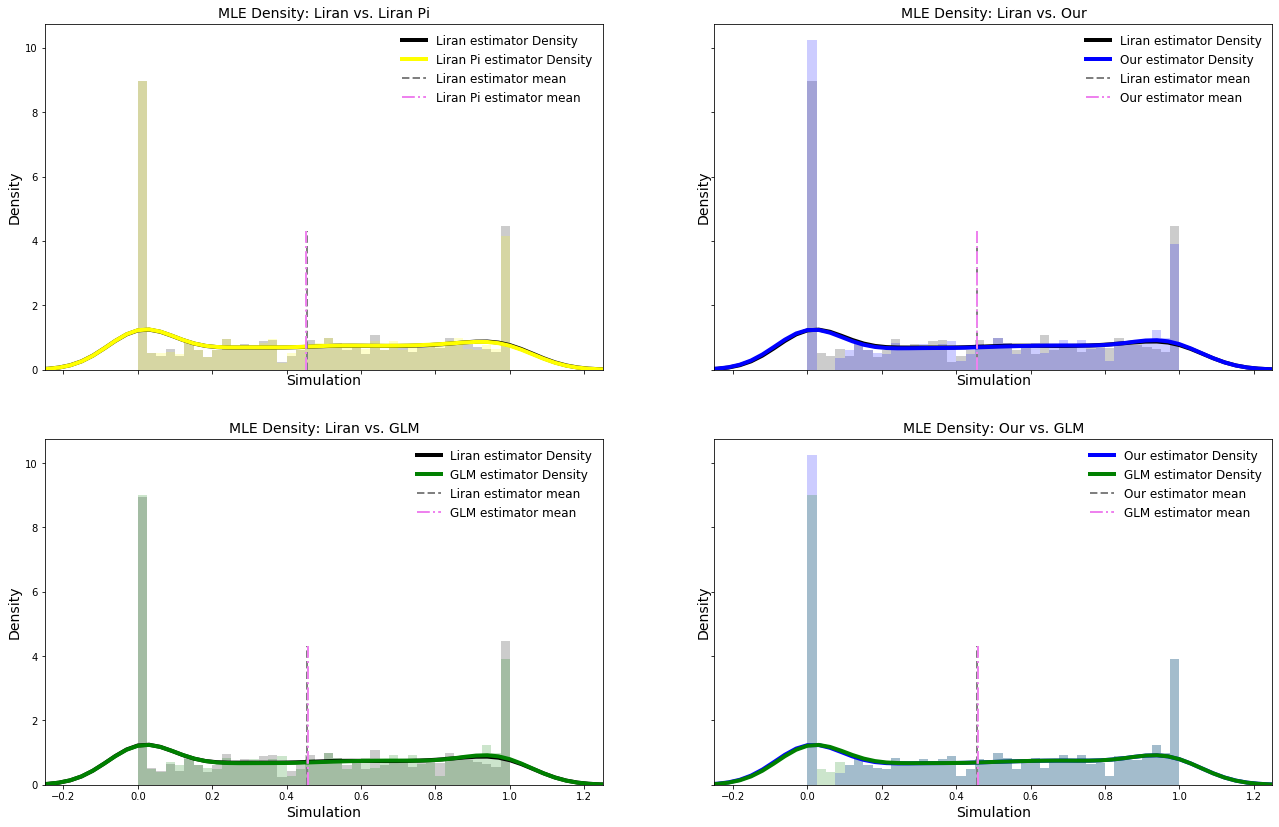

In [18]:
make_densities(output7['output_est'])

In [73]:
df = output['output_est']

In [43]:
output.keys()

dict_keys(['t_list', 'liran_list', 'liran_pi_list', 'our_list', 'glm_list', 'liran_sd_list', 'our_sd_list', 'pi_list', 'pi_mean_list', 'm_list', 'output_est', 'output_df'])

In [41]:
df.head()

,true_m,liran,liran_pi,our,glm
0,0.622010,0.394089,0.547345,0.608354,0.608356
1,0.386243,0.321983,0.329121,0.323403,0.323403
2,0.307457,0.396636,0.404531,0.573076,0.573075
3,0.792739,0.736995,0.667735,0.737332,0.737331
4,0.761458,0.775983,0.705020,0.785794,0.785790


In [48]:
sumT = [i.sum() for i in output['t_list']]

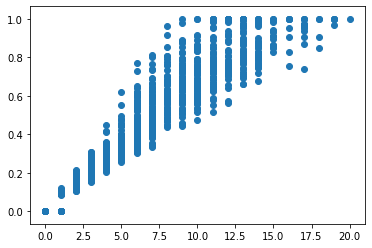

In [50]:
plt.scatter(sumT,df.our,)

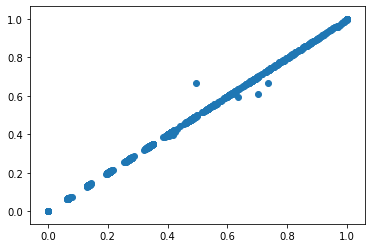

In [74]:
plt.scatter(df.liran,df.liran_pi)

In [60]:
# Parameters:
# General:
###########################################
sample_len = 1000 # "DNA" sample length-> N
coverage_mean  = 200
coverage_sd = 5
#m_mean =  0.6
m_sd = 0.05
m_low = 0.2
m_high = 0.8
# Parameters for complex model:
m_initial_guess = 0.5 # for complex model
###########################################

# list objects for accounting:
t_list = []
est_simple_list = []
sd_simple_list = []
est_complex_list = []
sd_complex_list = []
pi_list = []
pi_mean_list = []
m_list = []
###########################################

# Simulating Data:
rng = range(0,sample_len) 
for i in rng:
    # Sampling m_i:
    #m = np.random.normal(m_mean, m_sd)
    m = random.sample([m_low,m_high],1)[0]
    m = np.random.normal(m,m_sd,1)
    #random.sample(np.random.normal(m_low, m_sd),np.random.normal(m_high, m_sd),)
    #
    if m>=1:
        m  = 0.9999
    elif m <=0:
        m = 0.0001
    #Sampling coverage:
    coverage = int(np.random.normal(coverage_mean, coverage_sd))
    # Sampling pi_i and pi_i_zero from a uniform dist:
    #pi = np.random.uniform(low=0.02, high=0.8, size=coverage)
#     pi_dist = 2*[0.8]+2*[0.4]+2*[0.2]+(coverage-6)*[0.02]
#     pi = np.array(random.choices(pi_dist,k=coverage))
    pi_dist = [0.4,0.3,0.2,0.1]
    weights = [5/50,5/50,5/50,35/50]
    pi = np.array(random.choices(pi_dist,weights=weights,k=coverage))
    theta = pi*m # Defining theta
    # Limiting theta:
    theta[theta>0.999]=0.9999
    theta[theta<0]=0.0001
    # Sampling t_i from a binomial(theta):
    t = np.random.binomial(1,theta)
    while sum(t==0)==len(t):
        t = np.random.binomial(1,theta)
    
    
    # Estimating using Liran's:
    pi_calib =  0.1597686029694
    solution_simple = t.sum()/(coverage*pi_calib) #MLE: m_i = t_i/(pi*n_i)
#     if solution_simple<0:
#         solution_simple=0
#     if solution_simple >1:
#         solution_simple = 1
    est_simple_list.append(solution_simple)
    sd_simple_list.append(np.sqrt(1/(-SOC_binom(t,pi_calib, solution_simple, coverage))))
    
    # Estimating m_i using complex model: 
    solution = fsolve(FOC, m_initial_guess,args=(coverage,pi,t))[0]
    #solution = sp.optimize.brentq(FOC,a = 0, b = 1 ,args=(coverage,pi,t))
    #solution = sp.optimize.root_scalar(FOC,args=(coverage,pi,t),bracket=[0,1], method='bisect').root
#     if solution<0:
#         solution=0
#     if solution >1:
#         solution = 1
    est_complex_list.append(solution)
    sd_complex_list.append(np.sqrt(1/(-SOC(solution,coverage,pi,t))))
    
    # Accounting:
    pi_list.append(pi)
    pi_mean_list.append(pi.mean())
    m_list.append(m[0])
    t_list.append(t)
    
output_df = pd.DataFrame(list(zip(m_list, pi_list ,t_list)), 
               columns =['samp_m', 'samp_p','samp_t'])
output_est = pd.DataFrame(list(zip(m_list,est_simple_list,est_complex_list)),columns =['true_m','liran','ours'])
#output_df.to_pickle('/Users/leecarlin/Dropbox (Personal)/School/deamination/simulation_MLE_35_coverage.pickle')

print('The empirical mean of m: {:,}'.format(np.array(m_list).mean()))
print('The empirical mean of pi: {:,}'.format(np.array(pi_mean_list).mean()))
print('The empirical mean of theta: {:,}'.format(np.array(pi_mean_list).mean()*np.array(m_list).mean()))

print('The mean of the simple model estimation: {:,}'.format(np.array(est_simple_list).mean()))
print('The mean of the complex model estimation: {:,}'.format(np.array(est_complex_list).mean()))
print('The std of the simple model estimation: {:,}'.format(np.array(est_simple_list).std()))
print('The std of the complex model estimation: {:,}'.format(np.array(est_complex_list).std()))
print('The mean of the simple model MLE STD: {:,}'.format(np.array(sd_simple_list).mean()))
print('The mean of the complex model STD: {:,}'.format(np.array(sd_complex_list).mean()))
MSE_liran = np.sqrt(((np.array(est_simple_list)-np.array(m_list))**2).mean())
MSE = np.sqrt(((np.array(est_complex_list)-np.array(m_list))**2).mean())
print('RMSE of Lirans Model: {:,}'.format(MSE_liran))
print('RMSE of Our Model: {:,}'.format(MSE))
print('RMSE DIfference: {:%}'.format((MSE-MSE_liran)/MSE_liran))
fltrd = output_est[output_est.ours>=0]
MSE_liran_fltrs = np.sqrt(((fltrd.liran-fltrd.true_m)**2).mean())
MSE_ours_fltrs = np.sqrt(((fltrd.ours-fltrd.true_m)**2).mean())
print('RMSE of Lirans Model: {:,}'.format(MSE_liran_fltrs))
print('RMSE of Our Model: {:,}'.format(MSE_ours_fltrs))
print('RMSE DIfference: {:%}'.format((MSE_ours_fltrs-MSE_liran_fltrs)/MSE_liran_fltrs))

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


The empirical mean of m: 0.48489083586608467
The empirical mean of pi: 0.15997730920348474
The empirical mean of theta: 0.0775715311792848
The mean of the simple model estimation: 0.4839384628837547
The mean of the complex model estimation: -2.038356168822863e+82
The std of the simple model estimation: 0.3189988935027004
The std of the complex model estimation: 1.029306957516975e+83
The mean of the simple model MLE STD: 0.028949260721864555
The mean of the complex model STD: 1.4437160286238015e+81
RMSE of Lirans Model: 0.11298311655226158
RMSE of Our Model: 1.0492958455567398e+83
RMSE DIfference: 92871915519464054360540022802641200505627324265109025507414392526001723187454237736960.000000%
RMSE of Lirans Model: 0.11337738268311544
RMSE of Our Model: 0.10778325281300921
RMSE DIfference: -4.934079%


RMSE of Lirans Model: 0.12422547937451367
RMSE of Our Model: 0.11960961644528699
RMSE DIfference: -3.715714%


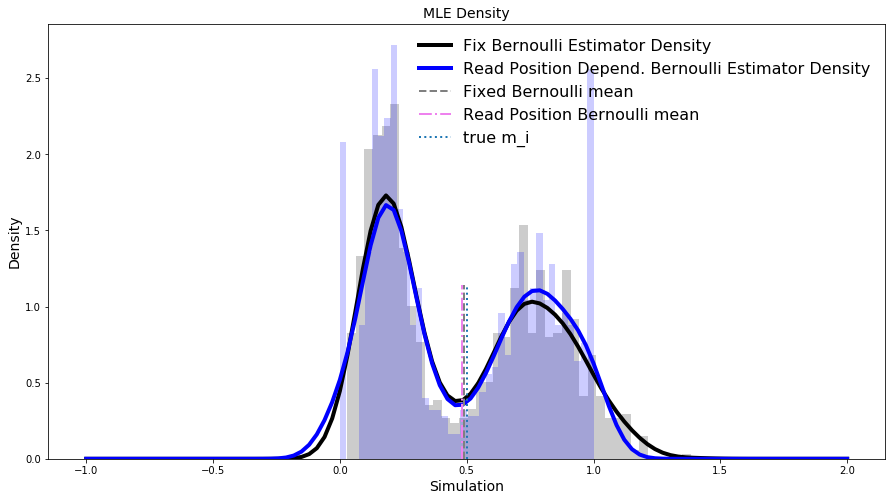

In [28]:
#Plot the distribution of our MLE and Lirans MLE 
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

from scipy.stats import gaussian_kde
density_liran = gaussian_kde(est_simple_list)
density_our = gaussian_kde(est_complex_list)
xs = np.linspace(-1,2,100)
#density.covariance_factor = lambda : .25
#density._compute_covariance()
ax.plot(xs,density_liran(xs), color = 'black', label = 'Fix Bernoulli Estimator Density',lw=4)
ax.hist(est_simple_list, density=True, bins= 40, alpha = 0.2, color = 'black')
ax.plot(xs,density_our(xs), color = 'blue', label = 'Read Position Depend. Bernoulli Estimator Density',lw=4)
ax.hist(est_complex_list, density=True, bins= 40, alpha = 0.2, color = 'blue')

ax.axvline(np.array(est_simple_list).mean(),ymin=0, ymax= 0.4,linestyle = '--', label='Fixed Bernoulli mean', color = 'grey',lw=2)
ax.axvline(np.array(est_complex_list).mean(),ymin=0, ymax= 0.4 ,linestyle = '-.', label='Read Position Bernoulli mean', color = 'violet',lw=2)
ax.axvline((m_low+m_high)/2,ymin=0, ymax= 0.4 ,linestyle = ':', label='true m_i',lw=2)
ax.legend(fontsize = 16,frameon = False)
plt.xlabel('Simulation', fontsize=14)
plt.ylabel('Density', fontsize=14)
ax.set_title('MLE Density', fontsize=14)
#fig.savefig('/Users/leecarlin/Dropbox (Personal)/School/deamination/deamination_report_20200528/fig1.png',dpi=400)
plt.show()

In [22]:
# tmp = pd.DataFrame(list(zip(np.array(est_simple_list)-np.array(m_list), np.array(est_complex_list)-np.array(m_list))), 
#                columns =['fixed_est', 'our_est'])
# #tmp = tmp.sort_values('our_est', ascending=False)
# fig = plt.figure(figsize = (15,8))
# ax = fig.add_subplot(111)
# density_diff_fixed = gaussian_kde(tmp.fixed_est)
# density_diff_our = gaussian_kde(tmp.our_est)
# xs = np.linspace(-0.5,0.5,100)
# #density.covariance_factor = lambda : .25
# #density._compute_covariance()
# ax.plot(xs,density_diff_fixed(xs), color = 'black', label = 'Fix Bernoulli Estimator Error Density',lw=4, )
# ax.plot(xs,density_diff_our(xs), color = 'blue', label = 'Read Position Bernoulli Estimator Error Density',lw=4)

# ax.axvline(0 ,linestyle = '--', label='Zero Error', color = 'grey',lw=2)
# ax.set_title('Density comparison of MLE errors from True $m_i$ for Fixed vs. Read Position Model', fontsize=14)
# ax.legend()
# #fig.savefig('/Users/leecarlin/Dropbox (Personal)/School/deamination/deamination_report_20200528/fig2.png',dpi=400)
# plt.show()

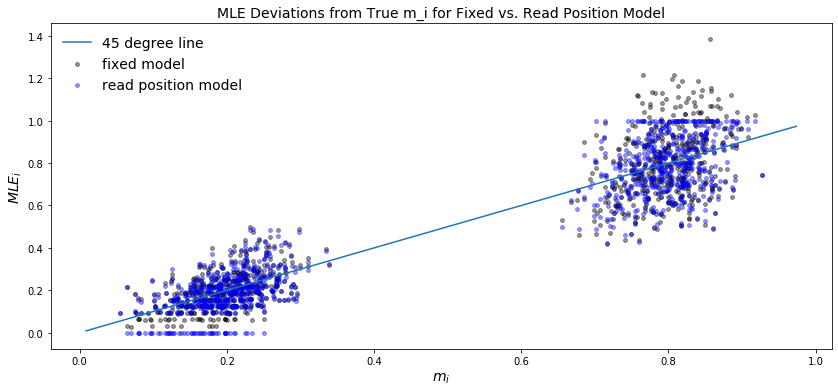

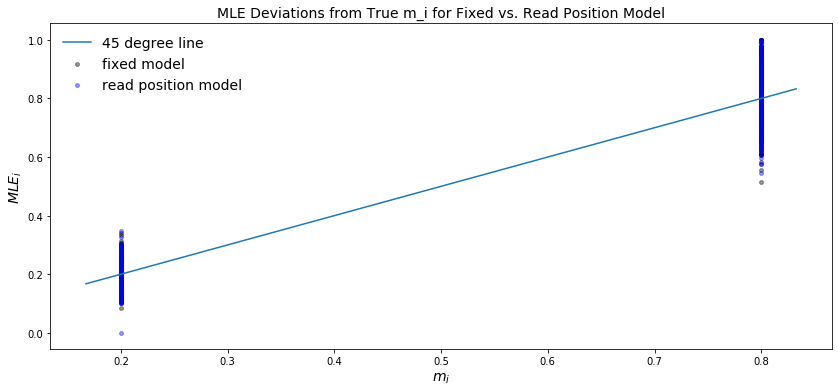

In [555]:
fig = plt.figure(figsize = (14,6))
ax = fig.add_subplot(111)
ax.scatter(m_list,est_simple_list, color='black', alpha = 0.4, label = 'fixed model', s=15 )
ax.scatter(m_list,est_complex_list, color='blue', alpha = 0.4, label = 'read position model', s=15)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, label = '45 degree line')
ax.set_title('MLE Deviations from True m_i for Fixed vs. Read Position Model', fontsize=14)
plt.xlabel('$m_i$', fontsize=14)
plt.ylabel('$MLE_i$', fontsize=14)
plt.legend(loc='upper left',frameon = False,fontsize= 14)
fig.savefig('/Users/leecarlin/Dropbox (Personal)/School/deamination/deamination_report_may_2020/fig3.png',dpi=400)
plt.show()